In [1]:
import os
import workspace_path
os.chdir(workspace_path.path)

## 载入模型和配置文件

In [2]:
from mmengine import Config
from mmseg.apis import init_model
#=====================================我的模型======================================
# cfg = Config.fromfile('myFolder/work_dirs/ZihaoDataset-FastSCNN/ZihaoDataset_FastSCNN_20230712.py')
# checkpoint_path = 'myFolder/work_dirs/ZihaoDataset-FastSCNN/best_mIoU_iter_23500.pth'

cfg = Config.fromfile('myFolder/work_dirs/ZihaoDataset-DeepLabV3plus/ZihaoDataset_DeepLabV3plus_20230712.py')
checkpoint_path = 'myFolder/work_dirs/ZihaoDataset-DeepLabV3plus/best_mIoU_iter_19500.pth'

# cfg = Config.fromfile('myFolder/work_dirs/ZihaoDataset-PSPNet/ZihaoDataset_PSPNet_20230712.py')
# checkpoint_path = 'myFolder/work_dirs/ZihaoDataset-PSPNet/iter_40000.pth'

#===================================子豪兄的模型====================================
# cfg = Config.fromfile('myFolder/checkpoint/watermelon/UNet/ZihaoDataset_UNet_20230712.py')
# checkpoint_path = 'myFolder/checkpoint/watermelon/UNet/Zihao_UNet.pth'

# cfg = Config.fromfile('myFolder/checkpoint/watermelon/KNet/ZihaoDataset_KNet_20230712.py')
# checkpoint_path = 'myFolder/checkpoint/watermelon/KNet/Zihao_KNet.pth'

# cfg = Config.fromfile('myFolder/checkpoint/watermelon/PSPNet/ZihaoDataset_PSPNet_20230712.py')
# checkpoint_path = 'myFolder/checkpoint/watermelon/PSPNet/Zihao_PSPNet.pth'

# cfg = Config.fromfile('myFolder/checkpoint/watermelon/Segformer/ZihaoDataset_Segformer_20230712.py')
# checkpoint_path = 'myFolder/checkpoint/watermelon/Segformer/Zihao_Segformer.pth'

# cfg = Config.fromfile('myFolder/checkpoint/watermelon/FastSCNN/ZihaoDataset_FastSCNN_20230712.py')
# checkpoint_path = 'myFolder/checkpoint/watermelon/FastSCNN/Zihao_FastSCNN.pth'
model = init_model(cfg, checkpoint_path, device='cuda:0')

E:\Code\openmmlab\mmsegmentation\mmseg\models\builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
E:\Code\openmmlab\mmsegmentation\mmseg\models\losses\cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: myFolder/work_dirs/ZihaoDataset-DeepLabV3plus/best_mIoU_iter_19500.pth


## 载入测试集图像

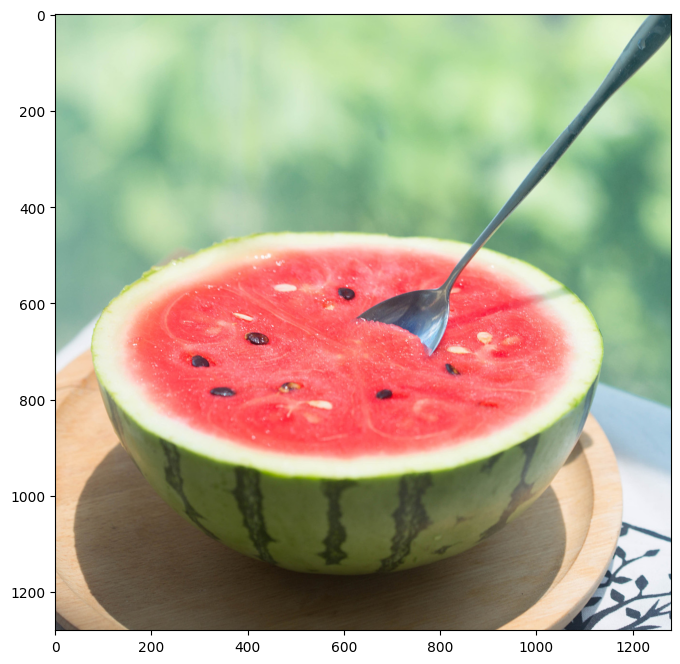

In [3]:
img_test_path = 'data/Watermelon87_Semantic_Seg_Mask/img_dir/val/01bd15599c606aa801201794e1fa30.jpg'

import cv2
import matplotlib.pyplot as plt
img_bgr = cv2.imread(img_test_path)
plt.figure(figsize=(8, 8))
plt.imshow(img_bgr[:,:,::-1])
plt.show()

## 语义分割预测

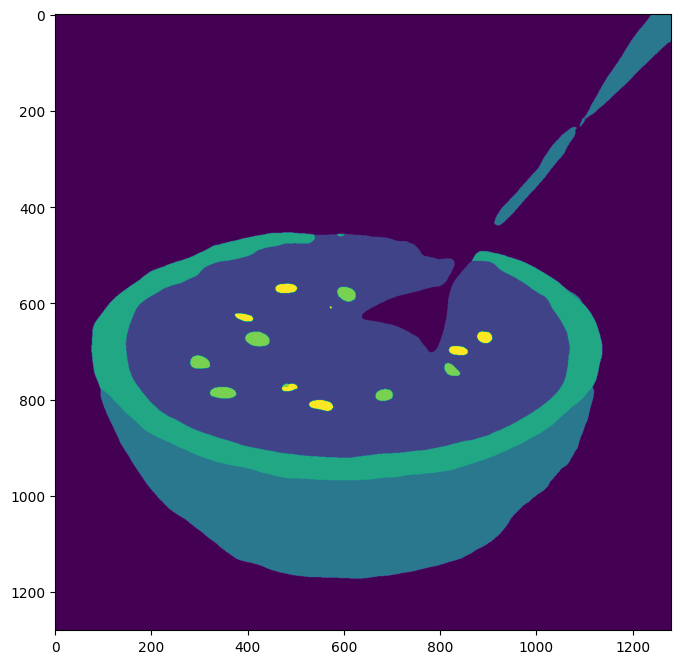

In [4]:
from mmseg.apis import inference_model
result = inference_model(model, img_bgr)
pred_mask = result.pred_sem_seg.data[0].cpu().numpy()
plt.figure(figsize=(8, 8))
plt.imshow(pred_mask)
plt.show()

## 可视化语义分割结果

### 方法一: 透明度叠加

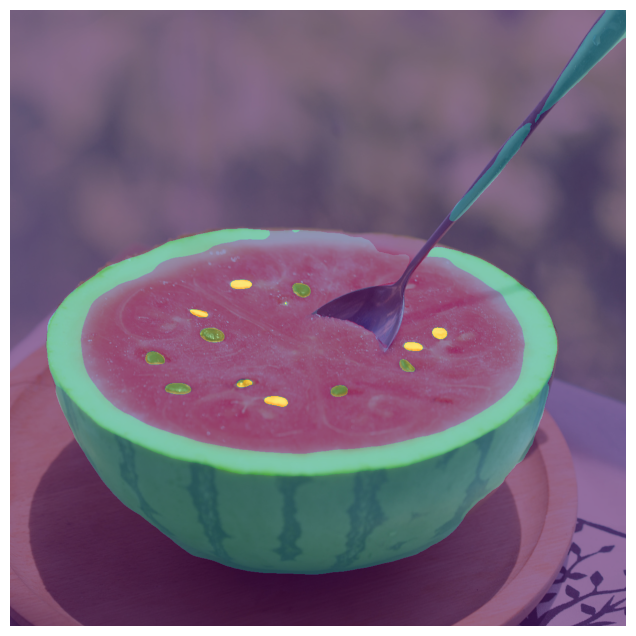

In [5]:
plt.figure(figsize=(10, 8))
plt.imshow(img_bgr[:,:,::-1])
plt.imshow(pred_mask, alpha=0.55) # alpha 高亮区域透明度，越小越接近原图
plt.axis('off')
plt.show()

### 方法二: 和原图并排显示

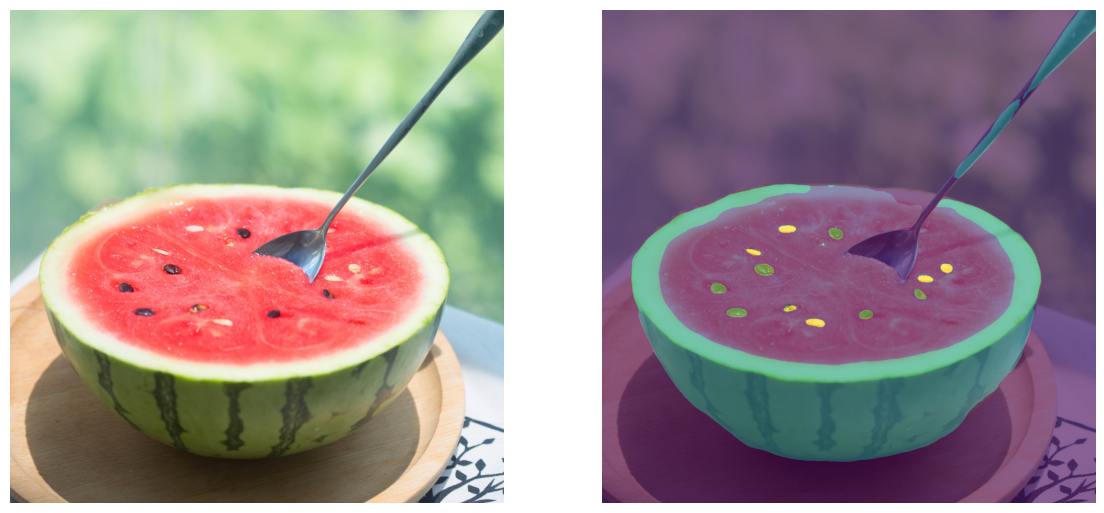

In [6]:
plt.figure(figsize=(14, 8))

plt.subplot(1,2,1)
plt.imshow(img_bgr[:,:,::-1])
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_bgr[:,:,::-1])
plt.imshow(pred_mask, alpha=0.6) # alpha 高亮区域透明度，越小越接近原图
plt.axis('off')
plt.show()

### 方法三: 按配色方案叠加在原图上显示

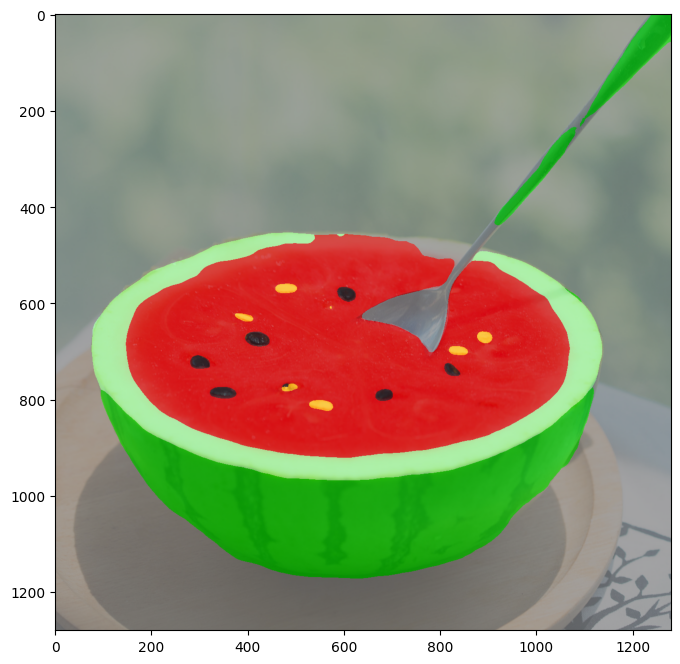

In [7]:
import numpy as np
# 各类别的配色方案（BGR）
palette = [
    ['background', [127,127,127]],
    ['red', [0,0,200]],
    ['green', [0,200,0]],
    ['white', [144,238,144]],
    ['seed-black', [30,30,30]],
    ['seed-white', [8,189,251]]
]
palette_dict = {}
for idx, each in enumerate(palette):
    palette_dict[idx] = each[1]
opacity = 0.3 # 透明度，越大越接近原图

# 将预测的整数ID，映射为对应类别的颜色
pred_mask_bgr = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3))
for idx in palette_dict.keys():
    pred_mask_bgr[np.where(pred_mask==idx)] = palette_dict[idx]
pred_mask_bgr = pred_mask_bgr.astype('uint8')

# 将语义分割预测图和原图叠加显示
pred_viz = cv2.addWeighted(img_bgr, opacity, pred_mask_bgr, 1-opacity, 0)

plt.figure(figsize=(8, 8))
plt.imshow(pred_viz[:,:,::-1])
plt.show()

### 方法四: 从`mmseg/datasets/`中读取配色方案,调用函数直接显示

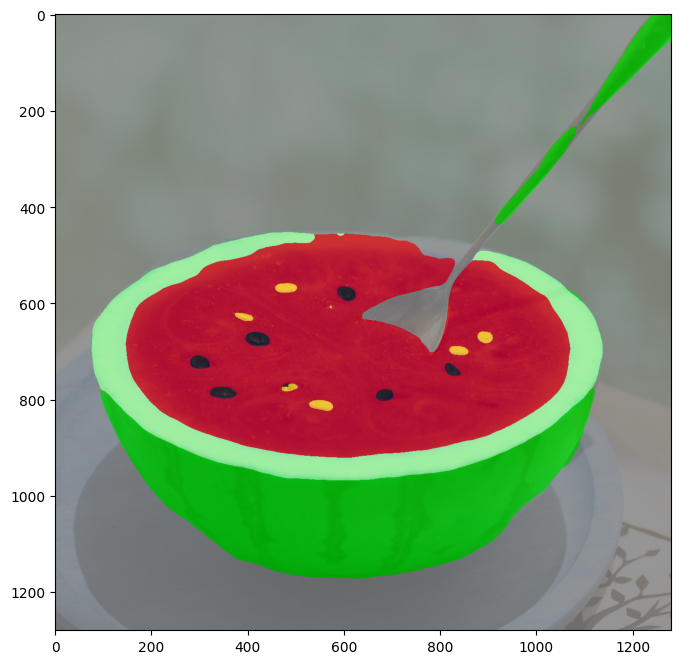

In [8]:
from mmseg.apis import show_result_pyplot
img_viz = show_result_pyplot(model, img_bgr, result, opacity=0.8, title='MMSeg', out_file='myFolder/outputs/K-4.jpg')
plt.figure(figsize=(14, 8))
plt.imshow(img_viz)
plt.show()

### 方法五: 加图例

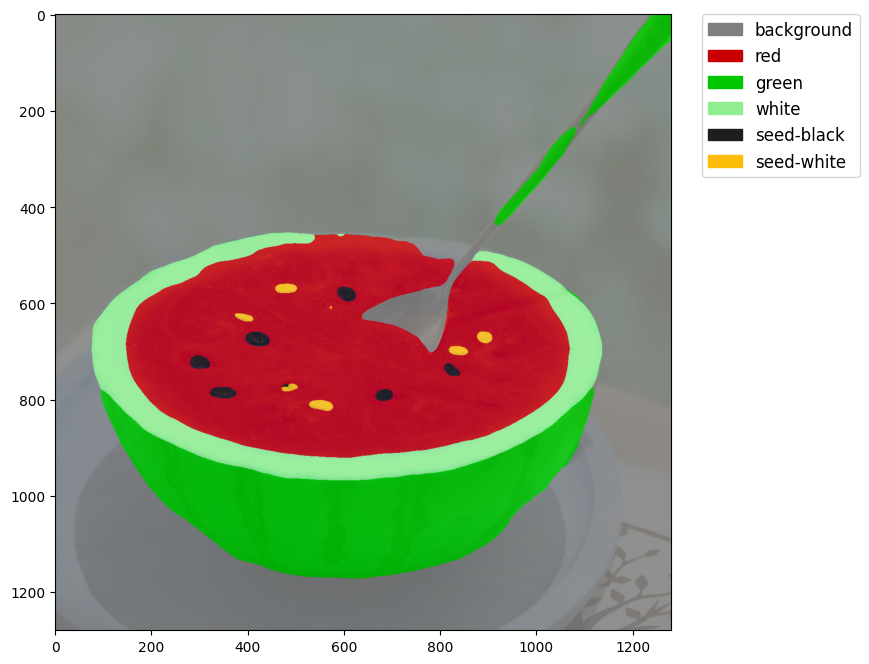

In [9]:
from mmseg.datasets import ZihaoDataset
import mmcv 
from PIL import Image
import matplotlib.patches as mpatches

# 获取类别名和调色板
classes = ZihaoDataset.METAINFO['classes']
palette = ZihaoDataset.METAINFO['palette']
opacity = 0.15 # 透明度，越大越接近原图

# 将分割图按调色板染色
seg_map = pred_mask.astype('uint8')
seg_img = Image.fromarray(seg_map).convert('P')
seg_img.putpalette(np.array(palette, dtype=np.uint8))

plt.figure(figsize=(14, 8))
img_plot = ((np.array(seg_img.convert('RGB')))*(1-opacity) + mmcv.imread(img_test_path)*opacity) / 255
im = plt.imshow(img_plot)

# 为每一种颜色创建一个图例
patches = [mpatches.Patch(color=np.array(palette[i])/255., label=classes[i]) for i in range(len(classes))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize='large')
plt.show()

## 获取测试集图像原始标注

In [10]:
img_test_label_path = 'data/Watermelon87_Semantic_Seg_Mask/ann_dir/val/01bd15599c606aa801201794e1fa30.png'

label = cv2.imread(img_test_label_path)
label.shape

(1280, 1280, 3)

三个通道值都一样, 取一个通道作为标注即可

In [11]:
label_mask = label[:,:,0]
np.unique(label_mask)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

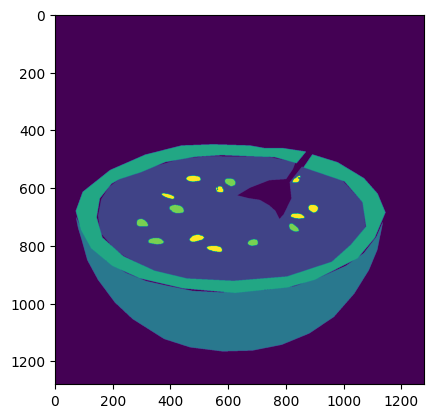

In [12]:
plt.imshow(label_mask)
plt.show()

## 对比语义分割预测与测试集标注结果

In [13]:
print(f"语义分割预测: {pred_mask.shape}, 测试集标注: {label_mask.shape}")

语义分割预测: (1280, 1280), 测试集标注: (1280, 1280)


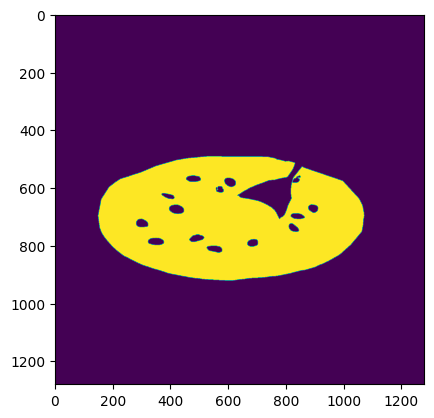

In [14]:
# 0:background; 1:red; 2:green; 3:white; 4:seed-black; 5:seed-white
TP = (label_mask == 1) & (pred_mask==1)
plt.imshow(TP)
plt.show()

## 绘制混淆矩阵

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix_model = confusion_matrix(label_mask.flatten(), pred_mask.flatten())

In [16]:
import itertools
def cnf_matrix_plotter(cm, classes, cmap=plt.cm.Blues):
    """
    传入混淆矩阵和标签名称列表，绘制混淆矩阵
    """
    plt.figure(figsize=(10, 10))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.colorbar() # 色条
    tick_marks = np.arange(len(classes))
    
    plt.title('Confusion Matrix', fontsize=30)
    plt.xlabel('Pred', fontsize=25, c='r')
    plt.ylabel('True', fontsize=25, c='r')
    plt.tick_params(labelsize=16) # 设置类别文字大小
    plt.xticks(tick_marks, classes, rotation=90) # 横轴文字旋转
    plt.yticks(tick_marks, classes)
    
    # 写数字
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 fontsize=12)

    plt.tight_layout()
    plt.show()

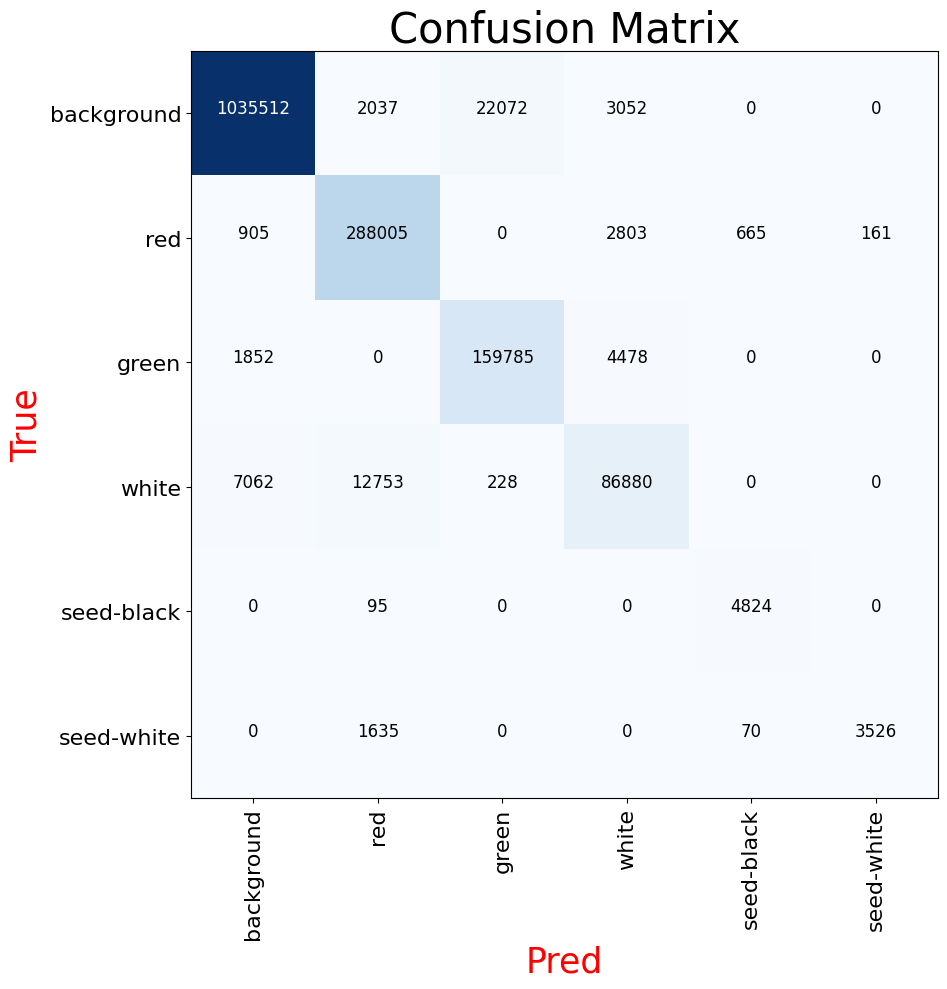

In [17]:
cnf_matrix_plotter(confusion_matrix_model, classes, cmap='Blues')